# 05. Baseline and Statistical Models

## Objective
- Xây dựng mô hình chuẩn so sánh
- Áp dụng mô hình thống kê có thời vụ

## 1. Setup and Load Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Add project root to path
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_data, save_file
from src.splitting import time_train_test_split
from src.evaluation import evaluate

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.10.11
Pandas version: 2.1.4
NumPy version: 1.26.4


In [2]:
# Load raw data using custom loader
try:
    df = load_data('data/processed/total_load.parquet')
    print("✅ Data loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"🕒 Time span: {df.index.min()} → {df.index.max()}")
    if not df.index.freq:
        df = df.asfreq("1H")
    print(f"🕒 Frequency: {df.index.freq}")
except Exception as e:
    print(f"❌ Error: {e}")

👉 Loading: data/processed/total_load.parquet
✅ Data loaded successfully!
📊 Shape: (35065, 1)
🕒 Time span: 2011-01-01 00:00:00 → 2015-01-01 00:00:00
🕒 Frequency: <Hour>


## 2. Data Splitting

In [3]:
train, test = time_train_test_split(df, test_size=0.2)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (28052, 1)
Test shape: (7013, 1)


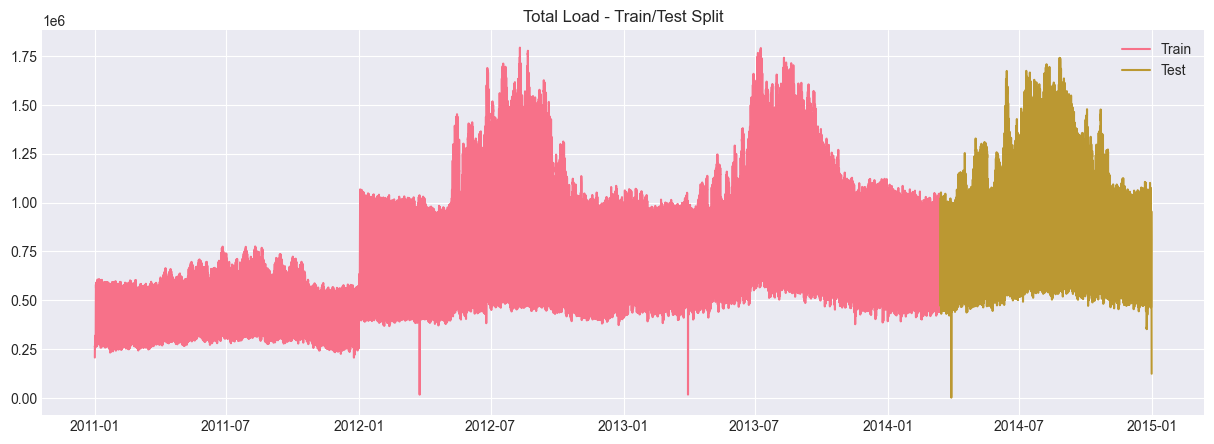

In [4]:
plt.figure(figsize=(15,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.title("Total Load - Train/Test Split")
plt.show()

## 3. Baseline Models

### 3.1 Naive Forecast

In [5]:
# Naive forecast
naive_forecast = train.iloc[-1, 0]

naive_pred = pd.Series(
    [naive_forecast] * len(test),
    index=test.index
)

### 3.2 Seasonal Naive Forecast

In [6]:
seasonal_naive_pred = df['total_load'].shift(168).loc[test.index]
seasonal_naive_pred.index = test.index

### 3.3 Evaluation
The Seasonal Naive model significantly outperformed the simple Naive forecast, confirming strong weekly seasonality in hourly electricity load. Therefore, seasonal statistical models such as SARIMA are appropriate for this dataset.

In [8]:
naive_metrics = evaluate(test, naive_pred)
seasonal_naive_metrics = evaluate(test, seasonal_naive_pred)

print("Naive:", naive_metrics)
print("Seasonal Naive:", seasonal_naive_metrics)

Naive: {'MAE': 301060.14, 'RMSE': 354481.69, 'MAPE': 50.83}
Seasonal Naive: {'MAE': 56295.34, 'RMSE': 90082.39, 'MAPE': 9.56}


## 4. Stationarity & Seasonality Analysis

### 4.1 ADF test
- We fail to reject the null hypothesis. (p=0.06 > 0.05)
- The series is non-stationary (borderline, but still non-stationary).

In [9]:
result = adfuller(train)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.7869297836031204
p-value: 0.06016514594189502


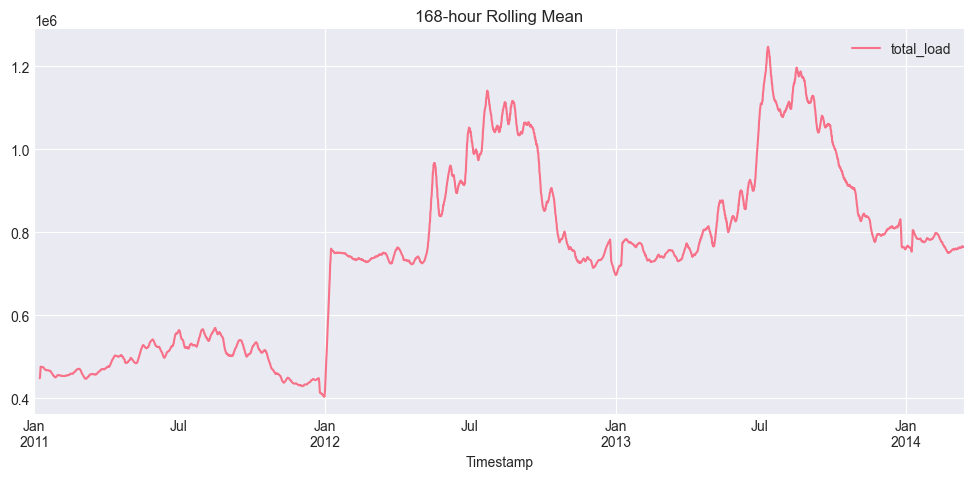

In [10]:
train.rolling(168).mean().plot(figsize=(12,5))
plt.title("168-hour Rolling Mean")
plt.show()

### 4.2 Differencing
The ADF test on the first-differenced series strongly rejects the null hypothesis of a unit root, indicating that the differenced series is stationary. Therefore, first differencing is sufficient and d = 1 is appropriate for this time series.

In [11]:
diff_1 = train.diff().dropna()

result_diff = adfuller(diff_1)

print("ADF after 1st differencing:")
print("Statistic:", result_diff[0])
print("p-value:", result_diff[1])

ADF after 1st differencing:
Statistic: -30.97756267691332
p-value: 0.0


### 4.3 Seasonal decomposition
The ADF test on the series after seasonal differencing (diff(168)) also strongly stationary. It has strong weekly seasonality → likely needs D = 1 

In [12]:
seasonal_diff = train.diff(168).dropna()

result_seasonal = adfuller(seasonal_diff)

print("ADF after seasonal differencing:")
print("Statistic:", result_seasonal[0])
print("p-value:", result_seasonal[1])

ADF after seasonal differencing:
Statistic: -12.508519843157039
p-value: 2.7066855852659533e-23


## 5. ARIMA(p,1,q) / SARIMA(p,1,q)(P,1,Q,168)

### 5.1 ACF/PACF
- The ACF plot shows a spike at lag 1 and a clear seasonal spike around lag 168, confirming remaining short-term and weekly autocorrelation structure after differencing.
- The PACF plot indicates a strong partial autocorrelation at lag 1 and at the seasonal lag 168, suggesting both non-seasonal and seasonal AR components in the model.

<Figure size 1200x500 with 0 Axes>

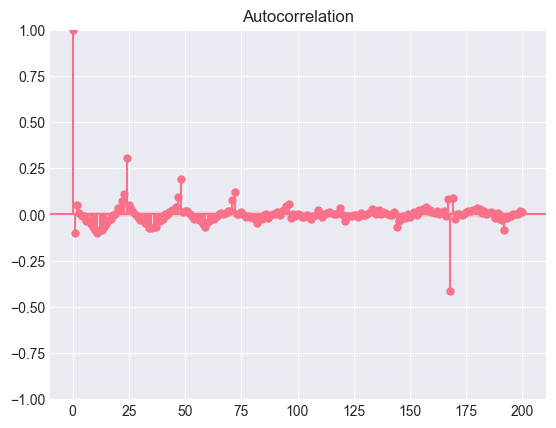

<Figure size 1200x500 with 0 Axes>

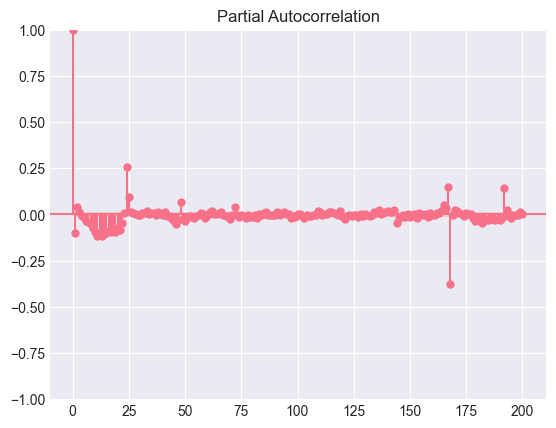

In [13]:
diff_final = train.diff().diff(168).dropna()

plt.figure(figsize=(12,5))
plot_acf(diff_final, lags=200)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(diff_final, lags=200)
plt.show()

### 5.2 Order selection
The strong performance of the Seasonal Naive model and the significant autocorrelation at lag 168 indicate pronounced weekly seasonality in the hourly electricity load. Since ARIMA models only capture non-seasonal dynamics, a SARIMA model was selected to explicitly account for both short-term and seasonal dependencies.

From ACF + PACF, a  very reasonable starting model is `SARIMA(1,1,1)(1,1,1,168)`
- p = 1 (PACF lag 1)
- q = 1 (ACF lag 1)
- P = 1 (PACF seasonal spike)
- Q = 1 (ACF seasonal spike)
- d = 1 (trend)
- D = 1 (weekly seasonality)
- s = 168

### 5.3 Model fitting
Since:
- 35k observations
- Seasonal period 168

Model fitting may take more time

In [ ]:
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,168),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

print(results.summary())

### 5.4 Residual diagnostics

### 5.5 Evaluation

## 6. Model Comparison
- Table of MAE / RMSE / MAPE
- Baseline vs ARIMA vs SARIMA

## 7. Preliminary Forecasting Results
- Short-term forecast plot
- Observations

## 8. Conclusion
- Why statistical models matter
- Limitations
- Transition to ML models